**Summary:** 
This tutorial shows the basic functions and usages of btk. For a more detailed understanding of the btk pipeline refer to the [User Guide](https://blendingtoolkit.readthedocs.io/en/latest/user_guide.html) on the package [website](https://blendingtoolkit.readthedocs.io/en/latest/index.html). 

For instructions on how to download required dependencies take a look at this [page](https://blendingtoolkit.readthedocs.io/en/latest/install.html).

# Setup

In [4]:
# Autoreload packages in case they change.
%load_ext autoreload
%reload_ext autoreload

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [6]:
sys.path.insert(0,os.path.dirname(os.getcwd())) # add BlendingToolKit so we can import btk 

In [7]:
import btk
import btk.plot_utils, btk.utils
from btk.obs_conditions import Rubin
from btk.create_observing_generator import ObservingGenerator
from btk.create_blend_generator import BlendGenerator
import astropy.table
import inspect
import descwl

In [8]:
import sklearn

In [9]:
import scarlet 
import scarlet.display

## Utility functions 

In [10]:
def make_histograms(*vals, labels=None, loc='best'):
    # make a histogram of each np.array in vals. 
    labels = labels if labels else [None]*len(vals)   
    bins = np.histogram(np.hstack(vals), bins=40)[1]  #get the bin edges
    for val, label in zip(vals, labels): 
        plt.hist(val, bins, label=label, histtype='step')
    plt.legend(loc=loc)

# Set Params 

In this first part we establish a set of parameters that we'll be using throughout the tutorial. You can think of them as user-defined global variables that are used throughout the simulations in BTK. 
These parameters will be fixed throughout this tutorial as well. 

Note that the `verbose` flag is turned off, in case you would like additional messages that show the functionality you can turn it on. 

In [11]:
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
max_number = 6 # Number of galaxies in a stamp
batch_size = 2 # Number of stamps in a batch
stamp_size = 24.0 # Size of the desired stamp, in arcsecs (default to 24.0)
survey = Rubin

np.random.seed(0)

# Load Catalog

Let's load the small catalog that we will be using. 

The file containing this catalog is defined in the `catalog_name` variable above.

In [12]:
catalog = btk.catalog.WLDCatalog.from_file(catalog_name)
catalog_full = catalog.get_raw_catalog()

# as you can see this is just a astropy table. 
print(type(catalog_full))
print(len(catalog_full))

<class 'astropy.table.table.Table'>
100


As you can see this catalog only contains 100 entries. 

In [13]:
# display available columns
catalog_full.colnames

['galtileid',
 'ra',
 'dec',
 'redshift',
 'fluxnorm_bulge',
 'fluxnorm_disk',
 'fluxnorm_agn',
 'a_b',
 'a_d',
 'b_b',
 'b_d',
 'pa_bulge',
 'pa_disk',
 'u_ab',
 'g_ab',
 'r_ab',
 'i_ab',
 'z_ab',
 'y_ab',
 'ref_mag',
 'btk_size']

## Selection function 

One can optionally apply selection function at this step, there is the basic selection function already implemented inside BTK in `btk.utils` that we will use as an example: 

In [14]:
# this function selects everything with i band mag < 27 and second moment size < 4 arcsecs 
print(inspect.getsource(btk.utils.basic_selection_function))

def basic_selection_function(catalog, max_size=4, max_mag=27):
    """Apply selection cuts to the input catalog.

    Only galaxies that satisfy the below criteria are returned:
    1) i band magnitude less than 27
    2) Second moment size is less than 4 arcsec.
    Second moments size (r_sec) computed as described in A1 of Chang et.al 2012

    Args:
        catalog: CatSim-like catalog from which to sample galaxies.

    Returns:
        CatSim-like catalog after applying selection cuts.
    """
    (q,) = np.where((catalog["btk_size"] <= max_size) & (catalog["ref_mag"] <= max_mag))
    return catalog[q]



As you can see in the function above, a `selection_function` simply takes in the catalog and 
returns a new (filtered) one. 

In the example below, we can see how the filtering of the `selection_function` reduced the number of objects.

In [15]:
# After defining the function, you can use it like: 
catalog = btk.catalog.WLDCatalog.from_file(catalog_name)
catalog.apply_selection_function(btk.utils.basic_selection_function)

table = catalog.table

len(table)

69

## Histograms 

Text(0.5, 0, 'i_ab')

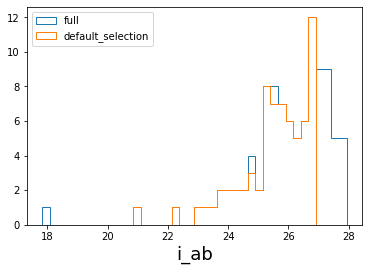

In [16]:
# let's see if our selection function is making sense by doing some histograms with the provided utility function.
labels = ['full', 'default_selection']
make_histograms(catalog_full['ref_mag'], table['ref_mag'], labels=labels, loc=2)
plt.xlabel('i_ab', size=18)

# Create blend generator (internal)

A `generator` is python jargon - it's a convenient data structure that only returns one object at a time. Never loading all of the objects into memory at once. 

`BTK` uses generators to create batches of images and corresponding parameters on the fly. We will now work on an example. 

The rest of this subsection describes the blend generator which is used internally by BTK ; you may skim it if you want to get directly to the blend drawing part.

A `blend_generator` uses a `SamplingFunction` object which defines how BTK generates and returns blends (groups of galaxies in a postage stamp that are considered 'blended' and that are drawn together). As you might expect, a `SamplingFunction` is required by BTK, but a default one can be used. Even though the `SamplingFunction` is not a true function, it can be called like one, hence its name.

In [17]:
sampling_function = btk.sampling_functions.DefaultSampling(max_number,
                                                           stamp_size) 
blend_generator = btk.create_blend_generator.BlendGenerator(catalog, 
                                                            sampling_function, 
                                                            batch_size)

Here is the `SamplingFunction` used:

In [18]:
print(inspect.getsource(btk.sampling_functions.DefaultSampling))

class DefaultSampling(SamplingFunction):
    def __init__(self, max_number=2, stamp_size=24.0, maxshift=None):
        """
        Default sampling function used for producing blend tables.
        Args:
            max_number (int): Defined in parent class
            stamp_size (float): Size of the desired stamp.
            maxshift (float): Magnitude of maximum value of shift. If None then it
                             is set as one-tenth the stamp size. (in arcseconds)
        """
        super().__init__(max_number)
        self.stamp_size = stamp_size
        self.maxshift = maxshift if maxshift else self.stamp_size / 10.0

    @property
    def compatible_catalogs(self):
        return "WLDCatalog", "CosmosCatalog"

    def __call__(self, table, shifts=None, indexes=None):
        """Applies default sampling to the input CatSim-like catalog and returns an
        astropy table with entries corresponding to a blend centered close to postage
        stamp center.

        Funct

The `SamplingFunction` should always be returning a `blend_catalog` from its `__call__` method, which is a (random) small subset from the catalog that defines a blend. In the example above, we are sampling a subset of size `number_of_objects` from the `catalog` after making a more stringent cut on i band magnitude and randomly shifting each galaxy from the center. 

In [ ]:
# to use the blend generator we use the 'next' python syntax
blend_catalog = next(blend_generator)

# blend catalog is a batch of list of astropy tables (# tables = batch_size)
# tables same format as original astropy catalog table. 
# objects in each table is variable and depends on params settings. 
blend_catalog

# Observing generator (internal)

This second generator is also used internally.

Now we turn to specifying the observational conditions for the blends created. Currently, the observing conditions are specified via the [WeakLensingDeblending](https://weaklensingdeblending.readthedocs.io/en/latest/) package (WLD), this package contains an object called `descwl.survey.Survey` that internally specifies observing conditions. Changeable parameters from the survey object include: 

- mirror_diameter
- effective_area 
- pixel_scale 
- airmass
- exposure_time
- sky_brightness 
- zenith_psf_fwhm
- zero_points
- extinction 

The PSF used for both the optics in the atmosphere are either a Moffat or Kolmogorov model. For more details see the [source code](https://github.com/ismael2395/WeakLensingDeblending/blob/master/descwl/survey.py) of `descwl.survey`.

The default observing conditions function in BTK are just constant across batches and will always return the defaults in the WLD package. 

In [19]:
print(inspect.getsource(btk.obs_conditions.WLDObsConditions))

class WLDObsConditions(ObsConditions):
    """Returns the default observing conditions from the WLD package
    for a given survey_name and band.
    """

    def __call__(self, survey, filt):
        pix_stamp_size = int(self.stamp_size / survey.pixel_scale)

        # get parameters for the descwl.Survey.survey object.
        survey_kwargs = descwl.survey.Survey.get_defaults(
            survey_name=survey.name, filter_band=filt.name
        )
        survey_kwargs["zero_point"] = filt.zero_point
        survey_kwargs["exposure_time"] = filt.exp_time
        # Ideally we would make use of filt.psf_scale and filt.mean_sky_level but those are not directly inputs of WLD, so it needs some thinking.
        survey_kwargs["image_width"] = pix_stamp_size
        survey_kwargs["image_height"] = pix_stamp_size
        survey_kwargs["no_analysis"] = True
        survey_kwargs["survey_name"] = survey.name
        survey_kwargs["filter_band"] = filt.name

        cutout = WLDCutout(self.stamp_s

In [20]:
observing_generator = ObservingGenerator(survey, stamp_size=stamp_size)
# A None value for the obs_conditions create default conditions for each band, using WLDObsConditions(stamp_size=24)

## Example of custom observing conditions 

Here is an example of a customized observing conditions function, different batches will have different observing conditions as they are produced. 

In [21]:
class CustomObsConditions(btk.obs_conditions.WLDObsConditions):
    def __init__(self,stamp_size=24):
        """Returns the default observing conditions from the WLD package
        for a given survey_name and band.
        """
        super().__init__(stamp_size)

    def get_cutout_params(self, survey_name, band, pixel_scale):
        # get default survey params
        pix_stamp_size = int(self.stamp_size / pixel_scale)
        cutout_params = descwl.survey.Survey.get_defaults(
            survey_name=survey_name, filter_band=band
        )
        cutout_params["image_width"] = pix_stamp_size
        cutout_params["image_height"] = pix_stamp_size
        cutout_params['exposure_time'] = random.uniform(10, cutout_params['exposure_time'])
        cutout_params['zenith_psf_fwhm'] += random.uniform(-0.3,0.3)


        # Information for WCS
        cutout_params["center_sky"] = None
        cutout_params["center_pix"] = None
        cutout_params["projection"] = "TAN"

        return cutout_params


In [22]:
# Here is how to use it: 
obs_conds = CustomObsConditions(stamp_size)
observing_generator = ObservingGenerator(survey, 
                                         obs_conds=obs_conds,
                                         stamp_size=stamp_size)

We will use this custom observing condition to create images in the next part. 

# Draw blends

## Setup

Here I'm just gathering all the results from the previous sections in case you want to experiment quickly by changing one of the generators. 

Remember that all the `None` statements below can be replaced with your favorite customized function, but I just let them be `None` here for simplicity (uses `BTK` default as explained in the sections above).  

In [23]:
# setup params and catalog 
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 
                            'data', 
                            'sample_input_catalog.fits')
catalog = btk.catalog.WLDCatalog.from_file(catalog_name)
sampling_function = btk.sampling_functions.DefaultSampling()
survey = Rubin

## Draw blend generator

Now we get to play with some images :) We will put together all the generators we have built so far and create some images simulated with `galsim` by interfacing with the WLD package and BTK. 

We first need a generator: `draw_blend_generator`. The `draw_blend_generator` directly creates the blend generator and observing generator using the sampling function, survey and obs conditions provided by the user.

In [24]:
#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.WLDGenerator(catalog,
                                                    btk.sampling_functions.DefaultSampling(),
                                                    survey,
                                                    batch_size=batch_size,
                                                    stamp_size=stamp_size) 

In [25]:
# This cell generates new `batch_size` number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

In [26]:
output.keys()

dict_keys(['blend_images', 'isolated_images', 'blend_list', 'obs_condition'])

Note the following: 

- Each time the function `next` is used on `draw_blend_generator` a fresh batch of data is simulated (based on your pre-specified `blend_generator` and `observing_generator`.

- The output of the `draw_blend_generator` is a `dict` containing the following: 

    - `blend_images`: A `np.array` of shape `batch_size x stamp_size x stamp_size x n_bands`. This contains the actual postage stamps with the blends.
                        
    - `isolated_images`: A `np.array` of shape `batch_size x max_objects x stamp_size x stamp_size x n_bands`. This contains the images that were added together the create the `blend_images`.   
    
    - `blend_list`: A list of `astropy.Table`s containing the source catalog of each blend in the batch. 
    
    - `obs_condition`: A list of `batch_size` of list of `n_bands` observing conditions  `n_bands` that is used for every element in the batch. 
    
    - `wcs`: A list of `astropy.wcs.WCS` objects, which can be used to convert sky coordinates to pixel coordinates (and reverse)

## Draw some blends!

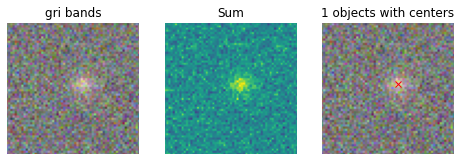

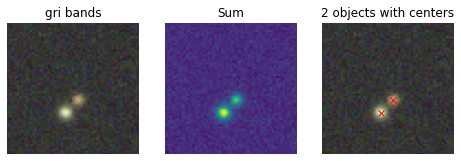

In [27]:
# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

#this also shows the true centers of the drawn galaxies with a red 'x'

In case you would also like to see each individual source in the blend you can take a look at the `isolated_images` 

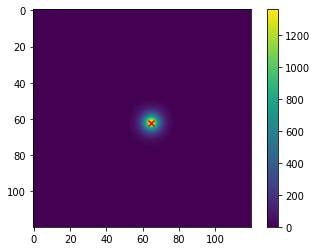

In [28]:
# plot the first source in the first blend in the 'i' band. 
# mark its appropriate position manually from the blend list. 
im = plt.imshow(isolated_images[0][0][...,3])
plt.scatter(blend_list[0][0]['dx'], blend_list[0][0]['dy'], marker='x', color='r')
plt.colorbar(im)


# Create Measure generator 

In this next part, we will see how we can combine the functionality of creating blends in BTK  with your favorite detection/deblending/measurement algorithms. 

For simplicity let's start by defining everything we did so far in one function. 

In [29]:
def get_draw_blend_generator():
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    batch_size = 2
    max_number = 5
    survey = Rubin
    stamp_size = 24.0
    sampling_function = btk.sampling_functions.DefaultSampling(max_number,stamp_size)
    np.random.seed(0)

    #Load input catalog
    catalog = btk.catalog.WLDCatalog.from_file(catalog_name)

    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.WLDGenerator(catalog,sampling_function,survey,batch_size=batch_size,stamp_size=stamp_size)
    return draw_blend_generator

In [30]:
draw_blend_generator = get_draw_blend_generator()

Measurement/Deblending in BTK is structured very similarly to the previous approaches: using a generator. The reason for this is that the measurement might produce additional images or data that is later summarized, so it makes sense to not store it all at once but rather aggregate at the end if desired. 

The functionality that a user needs to add to BTK in order to specify their own algorithm is summarized in a class `btk.measure.Measurement_params`. You need to implement at least one of two functions:

- `make_measurement`: Given a dictionary `data` (`output` in the above section) return an astropy table with the measurements you made (fluxes, shapes, size, etc.) for each object in the blend. 

- `get_deblended_images`: Return output of deblending algorithm as dict. 

We will now walk through an example demonstration. 

Here is an example class to perform peak detection with sklearn that is copied from `btk.utils` :

## Basic Detection algorithm 

In [31]:
from btk.measure import Measurement_params
class Basic_measure_params(Measurement_params):
    """Class to perform detection by identifying peaks with skimage"""

    def get_centers(self, image):
        # set detection threshold to 5 times std of image
        threshold = 5 * np.std(image)
        coordinates = skimage.feature.peak_local_max(image, min_distance=2,
                                                     threshold_abs=threshold)
        return np.stack((coordinates[:, 1], coordinates[:, 0]), axis=1)

    def get_deblended_images(self, data, index):
        """Returns scarlet modeled blend and centers for the given blend"""
        image = np.mean(data['blend_images'][index], axis=2)  # don't use multi-band information. 
        peaks = self.get_centers(image)
        return {'deblend_image': None, 'peaks': peaks}

In [32]:
#this is how we specify the measurement params
meas_params = btk.utils.Basic_measure_params()

In [33]:
# get generator that yields measured values by running the algorithm in the images from the draw_blend_generator. 
# you can also turn on multiprocessing in this step in case your algorithm is CPU intensive. 
meas_generator = btk.measure.MeasureGenerator(
        meas_params, get_draw_blend_generator())

Out of 5 objects, 4 detected, 1 undetected, & 0  spurious detections


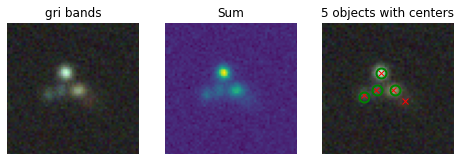

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


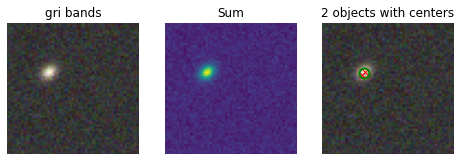

In [34]:
output, deb, _ = next(meas_generator)  # obtain simulation measurement output for this next batch. 
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

We can see how to basic `skimage` algorithm misses detection when the amount of blending is considerable. 

## Deblending with Scarlet 

There is already an implementation of Scarlet as `Measurement_params`, take a look in `utils.measure.Scarlet_params`. We will walk through it step by step in this section. 

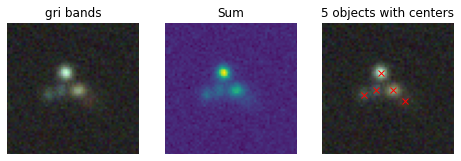

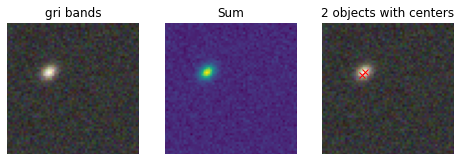

In [35]:
# get output from draw_blend_generator and let's look at the blends. 
output = next(get_draw_blend_generator())
blend_images = output['blend_images']
blend_list = output['blend_list']
obs_conds = output['obs_condition']
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

Let's try to deblend the second image which has two galaxies that look somewhat blended. 


In [36]:
catalog = blend_list[1] 

#make the order of the axis convention match that of scarlet 
images = np.transpose(blend_images[1], axes=(2,0,1))  # shape = (6, 120, 120 )

bands = np.array([obs_cond.filter_band for obs_cond in obs_conds], dtype=str)

 # use the true peaks and organize them. 
peaks = np.stack((catalog['dx'], catalog['dy']), axis=1) 

First we define an utility function for obtaining the true PSF used to create the image. 

In [37]:
from functools import partial 

def get_psf_sky(obs_cond, psf_stamp_size):
    """Returns postage stamp image of the PSF and mean background sky
    level value saved in the input obs_cond class
    Args:
        obs_cond:`descwl.survey.Survey` class describing observing
            conditions.
        psf_stamp_size: Size of postage stamp to draw PSF on in pixels.
    Returns:
        `np.ndarray`: Postage stamp image of PSF
        float: Mean of sky background

    """
    mean_sky_level = obs_cond.mean_sky_level
    psf = obs_cond.psf_model
    psf_image = psf.drawImage(
        scale=obs_cond.pixel_scale,
        nx=psf_stamp_size,
        ny=psf_stamp_size).array
    return psf_image, mean_sky_level

We now proceed to initialize scarlet, the following procedure is based heavily on the Scarlet tutorial which I recommend checking out: https://pmelchior.github.io/scarlet/0-quickstart.html

In [38]:
#create model psf. 
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(bands))

#create a frame for the model using the model_psf. 
model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=bands)

AttributeError: module 'scarlet' has no attribute 'GaussianPSF'

In [39]:
# Now we need to do some setting up to define the observation. 
psf_stamp_size=41
n_bands = len(bands)
psfs = np.zeros((n_bands, psf_stamp_size, psf_stamp_size),
                dtype=np.float32)
variances = np.zeros_like(images)

for i in range(n_bands): 
    psf, mean_sky_level = get_psf_sky(
        obs_conds[i], psf_stamp_size)
    psfs[i] = psf
    variances[i] = images[i] + mean_sky_level


In [40]:
# observation frame based on the image. 
observation = scarlet.Observation(
    images,
    psfs=scarlet.ImagePSF(psfs),
    weights=1. / variances,
    channels=bands).match(model_frame)

AttributeError: module 'scarlet' has no attribute 'ImagePSF'

In [41]:
#specify the fitting model using the true centers and some constraints. 
sources = []
for n, peak in enumerate(peaks):
    result = scarlet.ExtendedSource(
        model_frame, (peak[1], peak[0]), observation, thresh=1, shifting=True)
    sources.append(result)

NameError: name 'model_frame' is not defined

In [42]:
# perform the fit of the blended sscene. 
iters=200
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(iters, e_rel=1e-6)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

NameError: name 'observation' is not defined

In [43]:
# use an btk internal plotting tool to get the visualization. 
btk.plot_utils.show_scarlet_residual(blend, observation, limits=(30,90))

NameError: name 'blend' is not defined

In [ ]:
# Looks pretty good :) 

In case you want to look at what this function is doing internally: 

In [ ]:
# get the model resulting form the fit and render it into the observationn frame
# these resizes the model to the original image size. 
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_

# finally plot residual. 
plt.imshow(scarlet.display.img_to_rgb(residual))

### Scarlet integration with BTK  

`BTK` already has an implementation of Scarlet deblending where centers are obtained using `SEP`. So model might not be as good as the above depending on detection accuracy.

In [ ]:
meas_params = btk.utils.Scarlet_params(show_scene=True)
meas_generator = btk.measure.MeasureGenerator(
    meas_params, get_draw_blend_generator())
output, deb,_ = next(meas_generator)
blend_list = output['blend_list']
blend_images = output['blend_images']
deblend_images = [deb[i]['deblend_image'] for i in range(len(blend_list))]
detected_centers = [deb[i]['peaks'] for i in range(len(blend_list))]

# you would get a similar plot to the one above but you need SEP installed for this to work.

# Metrics

Now let's show how use metrics to evaluate your deblenders robustly over several batches. 

For this example we will use the LSST Stack for detection. 

In BTK, evaluating the detection efficiency of your algorithm is as easy as creating a children from the parent class `btk.compute_metrics.Metrics_params` 

In [ ]:
def get_meas_generator(meas_params):
    """Returns generator that yields output of user defined algorithm specified in meas_param.    
    Measurements are performed for default sampling function with maximum of 6 objects per blend.
    
    Returns:
        meas_generator: Generator that yeilds output of deblender and measurement algorithm..
    """
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    batch_size = 2
    max_number = 6
    survey_name = "LSST"
    stamp_size = 24.0
    np.random.seed(0)

    #Load input catalog
    catalog = btk.catalog.WLDCatalog.from_file(catalog_name)

    #Generate catalogs of blended objects 
    blend_generator = btk.create_blend_generator.BlendGenerator(catalog,btk.sampling_functions.DefaultSampling(max_number,stamp_size),batch_size)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.ObservingGenerator(survey,stamp_size=stamp_size, obs_conds=None)

    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.WLDGenerator(blend_generator, observing_generator)
    # get generator that yields measured values.
    meas_generator = btk.measure.MeasureGenerator(
            meas_params, draw_blend_generator)
    return meas_generator



In [ ]:
import astropy.table
class Stack_metric_params(btk.compute_metrics.Metrics_params):
    def __init__(self, *args, **kwargs):
        super(Stack_metric_params, self).__init__(*args, **kwargs)
        """Class describing functions to return results of
         detection/deblending/measurement algorithm in meas_generator. Each
         blend results yielded by the meas_generator for a batch.
    """

    def get_detections(self):
        """Returns blend catalog and detection catalog for detction performed

        Returns:
            Results of the detection algorithm are returned as:
                true_tables:  List of astropy Tables of the blend catalogs of the
                    batch. Length of tables must be the batch size. x and y coordinate
                    values must be under columns named 'dx' and 'dy' respectively, in
                    pixels from bottom left corner as (0, 0).
                detected_tables: List of astropy Tables of output from detection
                    algorithm. Length of tables must be the batch size. x and y
                    coordinate values must be under columns named 'dx' and 'dy'
                    respectively, in pixels from bottom left corner as (0, 0).
        """
        # Astropy table with entries corresponding to true sources
        blend_op, _, cat = next(self.meas_generator)
        true_tables = blend_op['blend_list']
        detected_tables = []
        for i in range(len(true_tables)):
            detected_centers = np.stack([cat[i]['base_NaiveCentroid_x'], cat[i]['base_NaiveCentroid_y']], axis=1)
            detected_table = astropy.table.Table(detected_centers,
                                                 names=['dx', 'dy'])
            detected_tables.append(detected_table)
        return true_tables, detected_tables

In [ ]:
# here we follow the same steps as before, and we specify the size of the test (how many batches)
meas_param = btk.utils.Stack_params()
meas_generator = get_meas_generator(meas_param)
metric_param = Stack_metric_params(meas_generator=meas_generator, batch_size=batch_size)
results = btk.compute_metrics.run(metric_param, test_size=10)
true_table, detected_table, detection_summary = results['detection']

In [ ]:
num = np.array(detection_summary).max()

_, ax = plt.subplots(1,3,figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#match1
det_summary = np.array(detection_summary)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])
print("match1", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[0])
ax[0].set_title('match1')
    
# match 2
summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
tot = np.sum(det_summary[:, 0])
det = np.sum(det_summary[:, 1])
spur = np.sum(det_summary[:, 3])

print("match2", "precision: ", float(det/(det + spur)), "recall: ", float(det/(tot)))
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[1])
ax[1].set_title('match2')

summ = np.array(detection_summary)
det_summary = np.concatenate([summ[:, 0, np.newaxis], summ[:, 5:]], axis=1)
det_summary[:, 1] += det_summary[:, 3] +det_summary[:, 4]
btk.plot_utils.plot_metrics_summary(det_summary, num, ax=ax[2])
ax[2].set_title('Blend')
ax[2].set_ylabel('# detected objects')